# Description

In this code, we perform logistic regression with forward selection. Formerly, we performed SMOTE, though we would ultimately find that this made the machines perform worse overall.

# Load the data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
df = pd.read_csv('./preprocessed_TJI_deaths.csv')

#Split into races

In [4]:
print('Before dropping race OTHER: ', df.shape[0])
df = df[df['race']!='OTHER']
print('After dropping race OTHER: ', df.shape[0])
df_white = df[df['race']=='WHITE']
df_black = df[df['race']=='BLACK']
df_hispanic = df[df['race']=='HISPANIC']

Before dropping race OTHER:  10713
After dropping race OTHER:  10620


In [5]:
print('White prisoners: ', df_white.shape)
print('Black prisoners: ', df_black.shape)
print('Hispanic prisoners: ', df_hispanic.shape)

White prisoners:  (4609, 10)
Black prisoners:  (3120, 10)
Hispanic prisoners:  (2888, 10)


# White logistic regression (w/ forward selection)

With SMOTE, each machine takes around 17 minutes to run. Without SMOTE, each takes about 6-8 minutes to run.

In [6]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import SelectKBest, f_classif
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [7]:
df_white = df[df['race']=='WHITE']

df_white_Y = df_white['Natural']
df_white_X = df_white.drop(['Natural', 'manner_of_death', 'race'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_white_X, df_white_Y, test_size=0.2)

In [8]:
numerical_columns = ['age_at_time_of_death', 'days_from_custody_to_death']
binary_columns = ['sex', 'Medical']
categorical_columns = [col for col in X_train.columns if col not in numerical_columns + binary_columns]

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('binary', OrdinalEncoder(), binary_columns)
])

model_white = LogisticRegression(max_iter=1000)

sfs_white = SFS(
    estimator = model_white,
    k_features = 'best',
    forward = True,
    scoring = 'accuracy',
    cv = 3,
    n_jobs = -1
)

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
#    ('smote', SMOTE(sampling_strategy='auto')),
    ('forward_selection', sfs_white),
    ('model', model_white)
])


cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__penalty' : ['l2'],
    'model__C' : np.logspace(-2, 2, 5),
    'model__solver' : ['lbfgs','liblinear']}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model_white = gridsearch.best_estimator_

CV-results:
 [0.90785908 0.90514905 0.90243902 0.90785908 0.89159892 0.91056911
 0.89701897 0.90217391 0.91304348 0.90217391] 
-------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'} 
-------------------------------


In [9]:

y_pred = best_model_white.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)


Test accuracy:  0.8937093275488069


In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[704  27]
 [ 71 120]]
              precision    recall  f1-score   support

     Natural       0.91      0.96      0.93       731
   Unnatural       0.82      0.63      0.71       191

    accuracy                           0.89       922
   macro avg       0.86      0.80      0.82       922
weighted avg       0.89      0.89      0.89       922



In [32]:
preprocess_pipeline = best_model_white.named_steps['preprocess']
one_hot = preprocess_pipeline.transformers_[1][1]

#Check the categories of the one-hot encoding:
categories_OH = one_hot.categories_
categories_OH = [category for feature in categories_OH for category in feature]
print(categories_OH)

#Check the ordinal encoding:
ordinal = preprocess_pipeline.transformers_[2][1]
categories_bin = ordinal.categories_
categories_bin = [category for feature in categories_bin for category in feature]

print(categories_bin)

#Check the label encoding:
model = best_model_white.named_steps['model']
print('Labels: ', model.classes_, "\n-------------------------------")

['JAIL - COUNTY', 'JAIL - MUNICIPAL', 'PRISON', 'PRIVATE FACILITY', 'Non-violent', 'Sexual', 'Violent', 'afternoon', 'morning', 'night']
['FEMALE', 'MALE', False, True]
Labels:  ['Natural' 'Unnatural'] 
-------------------------------


Pre-existing medical conditions is encoded as 1

In [36]:
weights_white = best_model_white.named_steps['model'].coef_

numerical_col = ['Age', 'Days']
categorical_col = categories_OH
binary_col = ['Male', 'Pre-existing conditions']

all_features = numerical_col + list(categorical_col) + list(binary_col)
#print(all_features)

sfs_white_steps = best_model_white.named_steps['forward_selection']
selected_features_white = [all_features[i] for i in sfs_white_steps.k_feature_idx_]

print(selected_features_white)


col_names = selected_features_white

coeff_df_white = pd.DataFrame(weights_white, columns = col_names, index = ['Unnatural causes'])
coeff_df_white = coeff_df_white.reset_index().rename(columns={'index': 'Cause'})

print(coeff_df_white)

['Age', 'JAIL - MUNICIPAL', 'PRISON', 'Sexual', 'afternoon', 'Male', 'Pre-existing conditions']
              Cause       Age  JAIL - MUNICIPAL    PRISON    Sexual  \
0  Unnatural causes -1.518019          0.887048 -1.404404 -0.113811   

   afternoon      Male  Pre-existing conditions  
0   0.099891  0.503861                -3.247646  


# Black logistic regression (w/ forward selection)

In [37]:
df_black_Y = df_black['Natural']
df_black_X = df_black.drop(['Natural', 'manner_of_death', 'race'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_black_X, df_black_Y, test_size=0.2)

In [38]:
numerical_columns = ['age_at_time_of_death', 'days_from_custody_to_death']
binary_columns = ['sex', 'Medical']
categorical_columns = [col for col in X_train.columns if col not in numerical_columns + binary_columns]

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('binary', OrdinalEncoder(), binary_columns)
])

model_black = LogisticRegression(max_iter=1000)

sfs_black = SFS(
    estimator = model_black,
    k_features = 'best',
    forward = True,
    scoring = 'accuracy',
    cv = 3,
    n_jobs = -1
)

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
#    ('smote', SMOTE(sampling_strategy='auto')),
    ('forward_selection', sfs_black),
    ('model', model_black)
])


cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__penalty' : ['l2'],
    'model__C' : np.logspace(-2, 2, 5),
    'model__solver' : ['lbfgs','liblinear']}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model_black = gridsearch.best_estimator_

CV-results:
 [0.884      0.916      0.896      0.904      0.892      0.896
 0.88353414 0.91164659 0.88353414 0.90361446] 
-------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'} 
-------------------------------


In [39]:
y_pred = best_model_black.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)

Test accuracy:  0.8798076923076923


In [40]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[514  17]
 [ 58  35]]
              precision    recall  f1-score   support

     Natural       0.90      0.97      0.93       531
   Unnatural       0.67      0.38      0.48        93

    accuracy                           0.88       624
   macro avg       0.79      0.67      0.71       624
weighted avg       0.86      0.88      0.87       624



In [41]:
weights_black = best_model_black.named_steps['model'].coef_

numerical_col = ['Age', 'Days']
categorical_col = categories_OH
binary_col = ['Male', 'Pre-existing conditions']

all_features = numerical_col + list(categorical_col) + list(binary_col)

sfs_black_steps = best_model_black.named_steps['forward_selection']
selected_features_black = [all_features[i] for i in sfs_black_steps.k_feature_idx_]

print(selected_features_black)


col_names = selected_features_black

coeff_df_black = pd.DataFrame(weights_black, columns = col_names, index = ['Unnatural causes'])
coeff_df_black = coeff_df_black.reset_index().rename(columns={'index': 'Cause'})

print(coeff_df_black)

['Age', 'Days', 'JAIL - MUNICIPAL', 'PRIVATE FACILITY', 'Non-violent', 'Sexual', 'Violent', 'night', 'Male', 'Pre-existing conditions']
              Cause       Age      Days  JAIL - MUNICIPAL  PRIVATE FACILITY  \
0  Unnatural causes -1.374484  0.052154          2.393192           1.62406   

   Non-violent   Sexual   Violent     night      Male  Pre-existing conditions  
0    -0.701755 -1.01168 -0.318498 -0.024116  0.673195                -2.772561  


# Hispanic logistic regression (w/ forward selection)

In [42]:
df_hispanic_Y = df_hispanic['Natural']
df_hispanic_X = df_hispanic.drop(['Natural', 'manner_of_death', 'race'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_hispanic_X, df_hispanic_Y, test_size=0.2)

In [43]:
numerical_columns = ['age_at_time_of_death', 'days_from_custody_to_death']
binary_columns = ['sex', 'Medical']
categorical_columns = [col for col in X_train.columns if col not in numerical_columns + binary_columns]

preprocess_pipeline = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('binary', OrdinalEncoder(), binary_columns)
])

model_hispanic = LogisticRegression(max_iter=1000)

sfs_hispanic = SFS(
    estimator = model_hispanic,
    k_features = 'best',
    forward = True,
    scoring = 'accuracy',
    cv = 3,
    n_jobs = -1
)

pipeline = Pipeline([
    ('preprocess', preprocess_pipeline),
#    ('smote', SMOTE(sampling_strategy='auto')),
    ('forward_selection', sfs_hispanic),
    ('model', model_hispanic)
])


cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring = 'accuracy')

print("CV-results:\n", cv_results, "\n-------------------------------")

cv = StratifiedKFold(n_splits=10)

param_grid = [
    {'model__penalty' : ['l2'],
    'model__C' : np.logspace(-2, 2, 5),
    'model__solver' : ['lbfgs','liblinear']}
]

gridsearch = GridSearchCV(pipeline, param_grid = param_grid, cv = cv, verbose=True, n_jobs=-1)

gridsearch.fit(X_train, y_train)

print("Best hyperparameters:", gridsearch.best_params_, "\n-------------------------------")

best_model_hispanic = gridsearch.best_estimator_

CV-results:
 [0.8961039  0.88311688 0.8961039  0.88744589 0.91774892 0.87445887
 0.9047619  0.9004329  0.9004329  0.8961039 ] 
-------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparameters: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'} 
-------------------------------


In [49]:
y_pred = best_model_hispanic.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print('Test accuracy: ', accuracy)

Test accuracy:  0.8996539792387543


In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_matrix)

print(classification_report(y_test, y_pred))

Confusion matrix:
 [[445  16]
 [ 42  75]]
              precision    recall  f1-score   support

     Natural       0.91      0.97      0.94       461
   Unnatural       0.82      0.64      0.72       117

    accuracy                           0.90       578
   macro avg       0.87      0.80      0.83       578
weighted avg       0.90      0.90      0.89       578



In [51]:
weights_hispanic = best_model_hispanic.named_steps['model'].coef_

numerical_col = ['Age', 'Days']
categorical_col = categories_OH
binary_col = ['Male', 'Pre-existing conditions']

all_features = numerical_col + list(categorical_col) + list(binary_col)
#print(all_features)

sfs_hispanic_steps = best_model_hispanic.named_steps['forward_selection']
selected_features_hispanic = [all_features[i] for i in sfs_hispanic_steps.k_feature_idx_]

print(selected_features_hispanic)


col_names = selected_features_hispanic

coeff_df_hispanic = pd.DataFrame(weights_hispanic, columns = col_names, index = ['Unnatural causes'])
coeff_df_hispanic = coeff_df_hispanic.reset_index().rename(columns={'index': 'Cause'})

print(coeff_df_hispanic)

['Age', 'JAIL - COUNTY', 'JAIL - MUNICIPAL', 'PRISON', 'PRIVATE FACILITY', 'Non-violent', 'morning', 'night', 'Male', 'Pre-existing conditions']
              Cause       Age  JAIL - COUNTY  JAIL - MUNICIPAL  PRISON  \
0  Unnatural causes -1.587667      -0.568713          2.116722 -1.8454   

   PRIVATE FACILITY  Non-violent   morning     night      Male  \
0          -0.60207    -0.159151  0.115409 -0.060601  1.033929   

   Pre-existing conditions  
0                -3.905675  


#Visualize weights

In [52]:
def visualize_weights(df_white, df_black, df_hisp):

  #Melt each dataframe into a long format
  df_white_melt = df_white.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Weight')
  df_black_melt = df_black.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Weight')
  df_hisp_melt = df_hisp.melt(id_vars = 'Cause', var_name = 'Feature', value_name='Weight')

  #Add race to long dfs
  df_white_melt['race'] = 'White'
  df_black_melt['race'] = 'Black'
  df_hisp_melt['race'] = 'Hispanic'

  #Combine the long dfs
  df_vis = pd.concat([df_white_melt, df_black_melt, df_hisp_melt])

  causes = df_vis['Cause'].unique()

  for cause in causes:

    cause_df = df_vis[df_vis['Cause']==cause]

    sns.barplot(x='Feature', y='Weight', hue='race',
              data=cause_df, ci=None, palette='muted')

    plt.title(f'Death by {cause}')

    plt.axhline(y=0)

    plt.xticks(rotation=90)

    plt.show()

<ipython-input-52-55b792eb2993>:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Feature', y='Weight', hue='race',


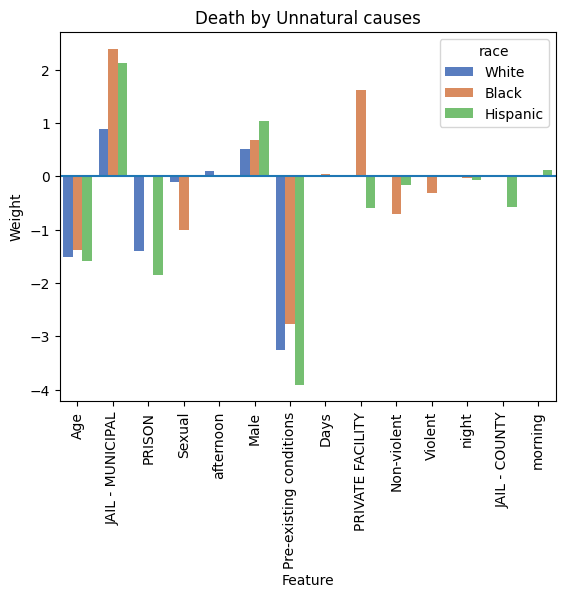

In [53]:
visualize_weights(coeff_df_white, coeff_df_black, coeff_df_hispanic)

#General remarks

With SMOTE, the results we see are slightly different. Refer to the paper for the interpretations of the weights. Meanwhile, the performance metrics have markedly improved. Although there is till a gap between precision and recall, all machines have improved in both of these metrics. The Black machine still performs the poorest.  